<a href="https://colab.research.google.com/github/Adityajaiswal03/OLA_caseStudy/blob/main/OLA_caseStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
!gdown 16g-OJ_4GnG0P8FEFgTa50RMubVSBvIZl

Downloading...
From: https://drive.google.com/uc?id=16g-OJ_4GnG0P8FEFgTa50RMubVSBvIZl
To: /content/ola_driver_scaler.csv
100% 1.13M/1.13M [00:00<00:00, 7.97MB/s]


In [4]:
df=pd.read_csv('/content/ola_driver_scaler.csv')

In [5]:
df.head()

/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.0+ MB


In [7]:
df.columns

Index(['Unnamed: 0', 'MMM-YY', 'Driver_ID', 'Age', 'Gender', 'City',
       'Education_Level', 'Income', 'Dateofjoining', 'LastWorkingDate',
       'Joining Designation', 'Grade', 'Total Business Value',
       'Quarterly Rating'],
      dtype='object')

## Data Engineering

In [8]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [9]:
df=df.rename(columns={'MMM-YY': 'Reporting_Date'})

In [10]:
df['Reporting_Date'] = pd.to_datetime(df['Reporting_Date'], format='%m/%d/%y',errors='coerce')
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'], format='%d/%m/%y',errors='coerce')
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'], format='%d/%m/%y',errors='coerce')

In [11]:
df['Driver_ID'].nunique()

2381

setting the target variable

In [12]:
target = df.groupby('Driver_ID')['LastWorkingDate'].last().isna().reset_index()
target['LastWorkingDate'] = target['LastWorkingDate'].map({True: 0, False: 1})
target.rename(columns={'LastWorkingDate': 'Target'}, inplace=True)
target.head()


,Driver_ID,Target
0,1,1
1,2,0
2,4,1
3,5,1
4,6,0


In [13]:
QR1 =  (df.groupby('Driver_ID').agg({'Quarterly Rating':'first'})['Quarterly Rating']).reset_index()
QR2 = (df.groupby('Driver_ID').agg({'Quarterly Rating':'last'})['Quarterly Rating']).reset_index()

In [14]:
QR1.shape,QR2.shape

((2381, 2), (2381, 2))

In [15]:
QR1.isna().sum(),QR2.isna().sum()

(Driver_ID           0
 Quarterly Rating    0
 dtype: int64,
 Driver_ID           0
 Quarterly Rating    0
 dtype: int64)

In [16]:
target = target.merge(QR1,on='Driver_ID')
target = target.merge(QR2,on='Driver_ID')

In [17]:
target['Rating_incr']=np.where(target['Quarterly Rating_x'] < target['Quarterly Rating_y'], 1,0)

In [18]:
target.head()

,Driver_ID,Target,Quarterly Rating_x,Quarterly Rating_y,Rating_incr
0,1,1,2,2,0
1,2,0,1,1,0
2,4,1,1,1,0
3,5,1,1,1,0
4,6,0,1,2,1


In [19]:
incm1 =  (df.groupby('Driver_ID').agg({'Income':'first'})['Income']).reset_index()
incm2 = (df.groupby('Driver_ID').agg({'Income':'last'})['Income']).reset_index()

In [20]:
incm1.shape,incm2.shape

((2381, 2), (2381, 2))

In [21]:
incm1.isna().sum(),incm2.isna().sum()

(Driver_ID    0
 Income       0
 dtype: int64,
 Driver_ID    0
 Income       0
 dtype: int64)

In [22]:
target = target.merge(incm1,on='Driver_ID')
target = target.merge(incm2,on='Driver_ID')

In [23]:
target['Income_incr'] = np.where(target['Income_x'] < target['Income_y'], 1,0)

In [24]:
target2=target[['Driver_ID','Target','Rating_incr','Income_incr']]

In [25]:
target2.head()

,Driver_ID,Target,Rating_incr,Income_incr
0,1,1,0,0
1,2,0,0,0
2,4,1,0,0
3,5,1,0,0
4,6,0,1,0


Aggerigating based on driver ID

In [26]:
df2=df.copy()

In [27]:
functions = {'Reporting_Date':'count',
             'Driver_ID':'first',
             'Age':'max',
             'Gender':'last',
            'City':'last',
             'Education_Level':'last',
             'Dateofjoining':'first',
            'LastWorkingDate':'last',
             'Grade':'last',
             'Total Business Value':'sum',
            'Income':'last',
             'Joining Designation':'last',
             'Quarterly Rating':'last'}
df2 = df2.groupby([df2['Driver_ID']]).aggregate(functions)
df2.rename(columns={'Reporting_Date':'Reportings'},inplace=True)

In [28]:
df2.reset_index(drop=True, inplace=True)
df2 = df2.merge(target2,on='Driver_ID')

In [29]:
df2.columns = df2.columns.str.strip()

checking for the null values

In [30]:
df2.isna().sum()

,0
Reportings,0
Driver_ID,0
Age,0
Gender,0
City,0
Education_Level,0
Dateofjoining,0
LastWorkingDate,765
Grade,0
Total Business Value,0


we are getting null values in Last working day as the driver hasn't left the company yet

Outliers

In [31]:
num_cols=['Reportings','Age','Total Business Value','Income']

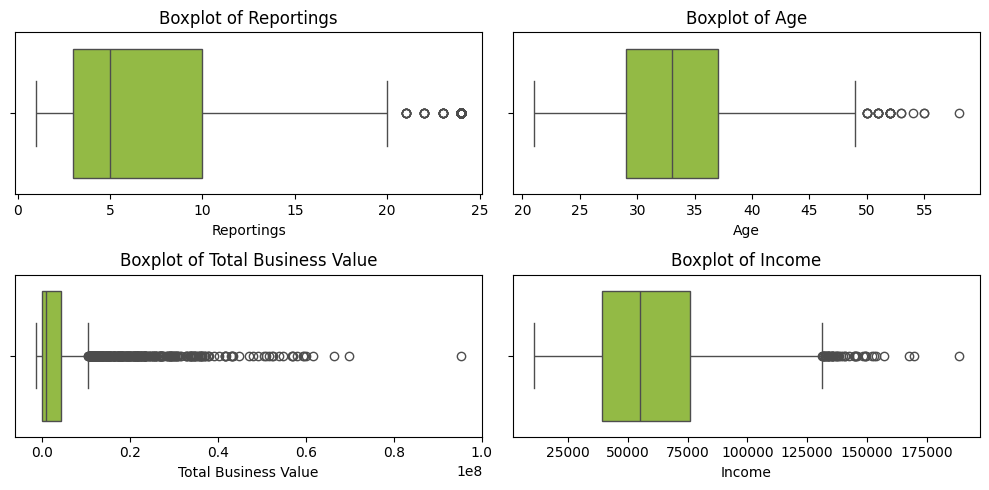

In [32]:
fig = plt.figure(figsize=(10,5))
i=1
for col in num_cols:
  ax = plt.subplot(2,2,i)
  sns.boxplot(x=df2[col],color='yellowgreen')
  plt.title(f'Boxplot of {col}')
  i += 1

plt.tight_layout()
plt.show()

Data is showing high outliers in Total Business value and Income

## EDA

In [33]:
data=df2.copy()


In [34]:
data.nunique()

,0
Reportings,24
Driver_ID,2381
Age,36
Gender,2
City,29
Education_Level,3
Dateofjoining,869
LastWorkingDate,493
Grade,5
Total Business Value,1629


In [35]:
data.describe()

,Reportings,Driver_ID,Age,Gender,Education_Level,Dateofjoining,LastWorkingDate,Grade,Total Business Value,Income,Joining Designation,Quarterly Rating,Target,Rating_incr,Income_incr
count,2381.00000,2381.000000,2381.000000,2381.000000,2381.00000,2381,1616,2381.000000,2.381000e+03,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000
mean,8.02352,1397.559009,33.663167,0.410332,1.00756,2019-01-27 12:58:58.009239808,2019-12-26 23:22:34.455445760,2.096598,4.586742e+06,59334.157077,1.820244,1.427971,0.678706,0.150357,0.018060
min,1.00000,1.000000,21.000000,0.000000,0.00000,2013-01-04 00:00:00,2018-12-31 00:00:00,1.000000,-1.385530e+06,10747.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,3.00000,695.000000,29.000000,0.000000,0.00000,2018-06-26 00:00:00,2019-06-10 00:00:00,1.000000,0.000000e+00,39104.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,5.00000,1400.000000,33.000000,0.000000,1.00000,2019-06-23 00:00:00,2019-12-20 12:00:00,2.000000,8.176800e+05,55315.000000,2.000000,1.000000,1.000000,0.000000,0.000000
75%,10.00000,2100.000000,37.000000,1.000000,2.00000,2020-04-14 00:00:00,2020-07-14 00:00:00,3.000000,4.173650e+06,75986.000000,2.000000,2.000000,1.000000,0.000000,0.000000
max,24.00000,2788.000000,58.000000,1.000000,2.00000,2020-12-28 00:00:00,2020-12-28 00:00:00,5.000000,9.533106e+07,188418.000000,5.000000,4.000000,1.000000,1.000000,1.000000
std,6.78359,806.161628,5.983375,0.491997,0.81629,NaN,NaN,0.941522,9.127115e+06,28383.666384,0.841433,0.809839,0.467071,0.357496,0.133195


In [36]:
cat_cols=['Gender','Education_Level','Grade','Joining Designation','Quarterly Rating','Rating_incr','Income_incr','Target']

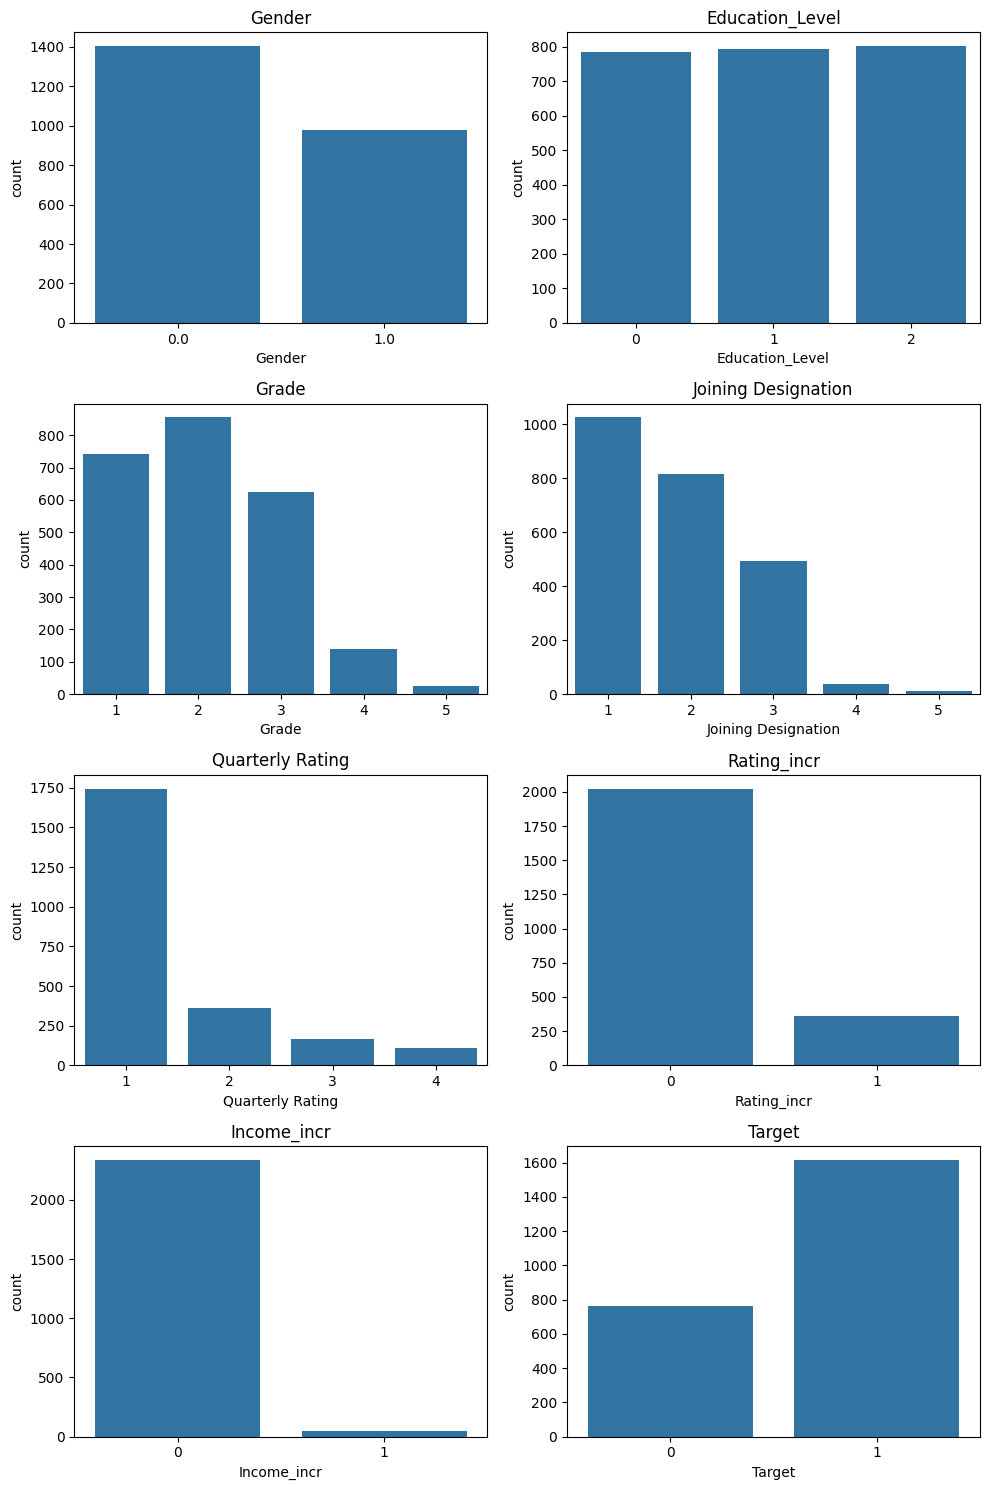

In [37]:
plt.figure(figsize=(10,15))
i=1
for col in cat_cols:
  ax=plt.subplot(4,2,i)
  sns.countplot(x=df2[col])
  plt.title(f'{col}')
  i += 1

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Distribution of City')

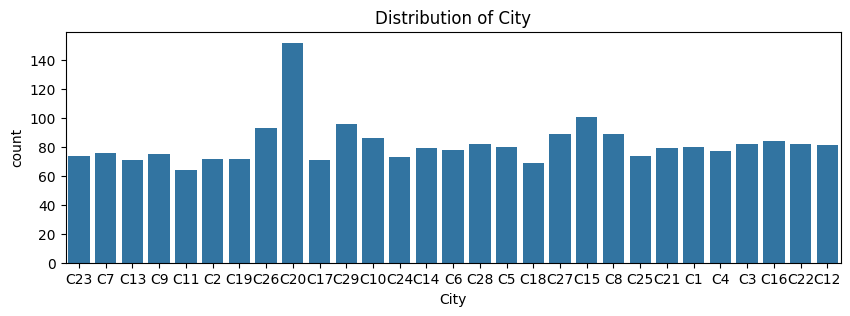

In [38]:
plt.figure(figsize=(10,3))
sns.countplot(x=df2['City'])
plt.title('Distribution of City')

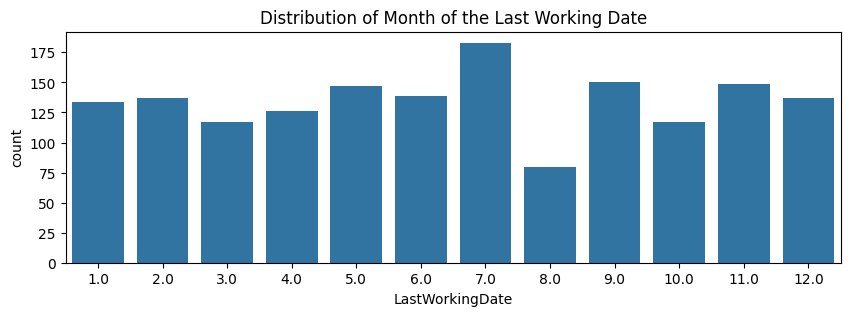

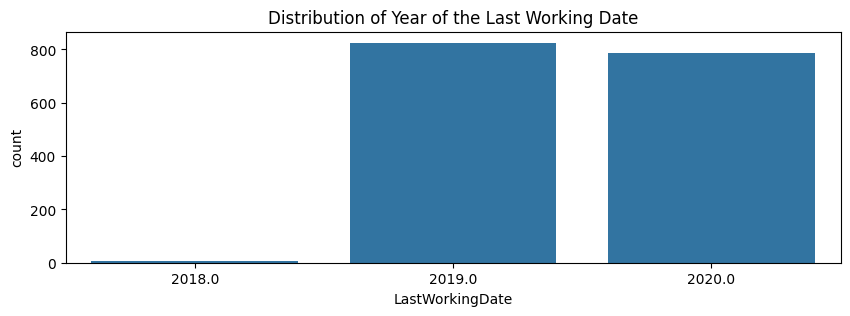

In [39]:
plt.figure(figsize=(10,3))
sns.countplot(x=df2['LastWorkingDate'].dt.month)
plt.title('Distribution of Month of the Last Working Date')

plt.figure(figsize=(10,3))
sns.countplot(x=df2['LastWorkingDate'].dt.year)
plt.title('Distribution of Year of the Last Working Date')

plt.show()

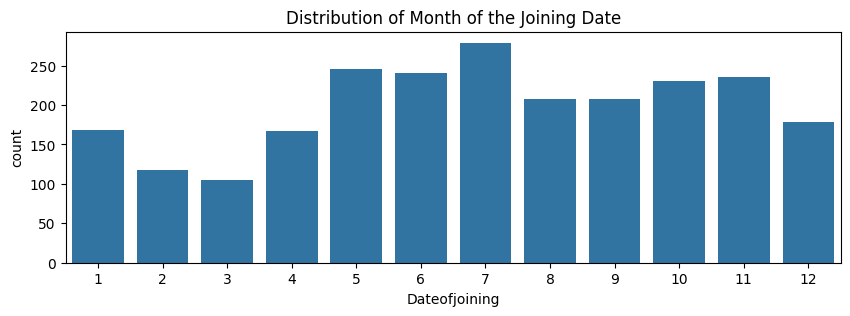

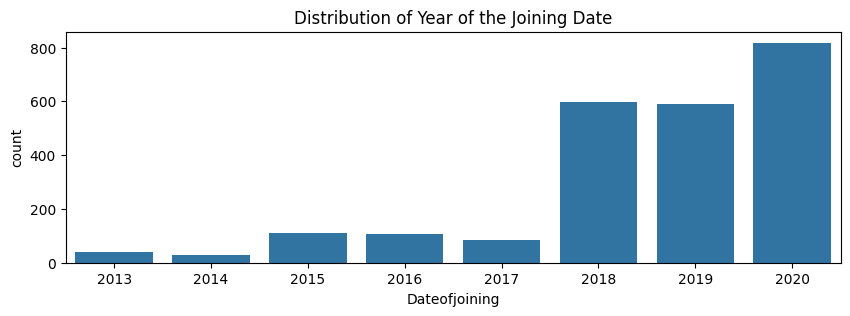

In [40]:
plt.figure(figsize=(10,3))
sns.countplot(x=df2['Dateofjoining'].dt.month)
plt.title('Distribution of Month of the Joining Date')

plt.figure(figsize=(10,3))
sns.countplot(x=df2['Dateofjoining'].dt.year)
plt.title('Distribution of Year of the Joining Date')

plt.show()

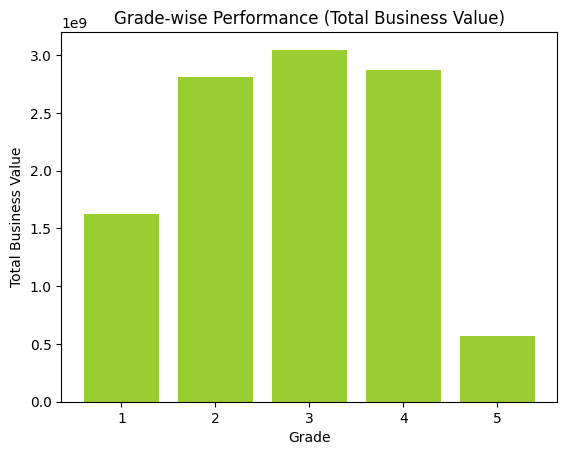

In [41]:

grade_wise_value = df2.groupby('Grade')['Total Business Value'].sum()

# Create the plot
plt.bar(grade_wise_value.index, grade_wise_value.values,color='yellowgreen')
plt.xlabel('Grade')
plt.ylabel('Total Business Value')
plt.title('Grade-wise Performance (Total Business Value)')
plt.show()


City with most improvement in Grade rating

In [42]:
data1=df.copy()

In [43]:
## with respect to the year of the last reporting Date

data1['Reporting_Date'] = pd.to_datetime(data1['Reporting_Date'])


last_date = data1['Reporting_Date'].max()
one_year_ago = last_date - pd.DateOffset(years=1)


df_past_year = data1[data1['Reporting_Date'] >= one_year_ago]


if df_past_year.empty:
    raise ValueError("No data available for the past year. Please check the date range or the data.")


rating_change = df_past_year.groupby('City').agg(
    start_rating=('Quarterly Rating', 'first'),
    end_rating=('Quarterly Rating', 'last')
).reset_index()


rating_change['rating_improvement'] = rating_change['end_rating'] - rating_change['start_rating']

In [44]:
if rating_change.empty or rating_change['rating_improvement'].isnull().all():
    raise ValueError("No improvements found. Please check the data.")


most_improved_city = rating_change.loc[rating_change['rating_improvement'].idxmax(), 'City']

print(f'The city with the most improvement in Quarterly Rating over the past year is: {most_improved_city}')


The city with the most improvement in Quarterly Rating over the past year is: C22


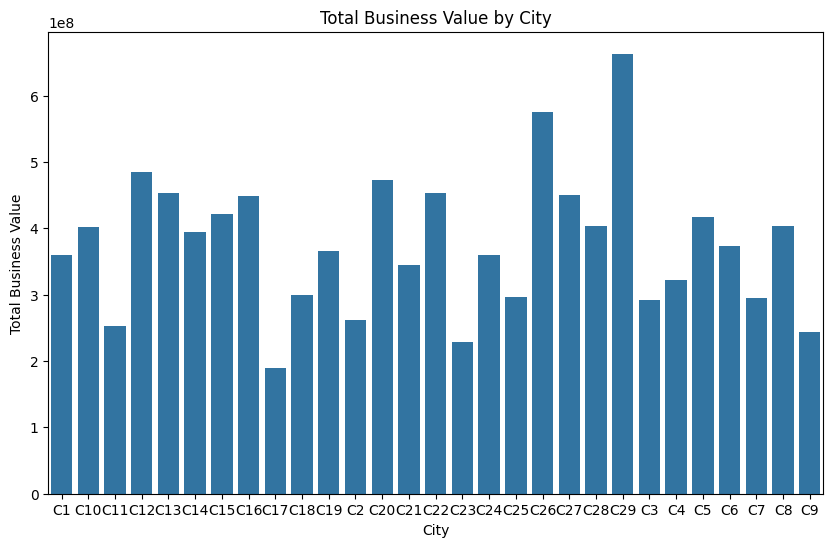

In [45]:
#Total business value x city

city_tbv = data1.groupby('City')['Total Business Value'].sum().reset_index()


plt.figure(figsize=(10, 6))
sns.barplot(data=city_tbv, x='City', y='Total Business Value')

# Add title and labels
plt.title('Total Business Value by City')
plt.xlabel('City')
plt.ylabel('Total Business Value')
plt.show()

Impact of Each column on churn

In [46]:
cat1_cols=['Gender','Education_Level','Grade','Joining Designation','Quarterly Rating','Rating_incr','Income_incr']

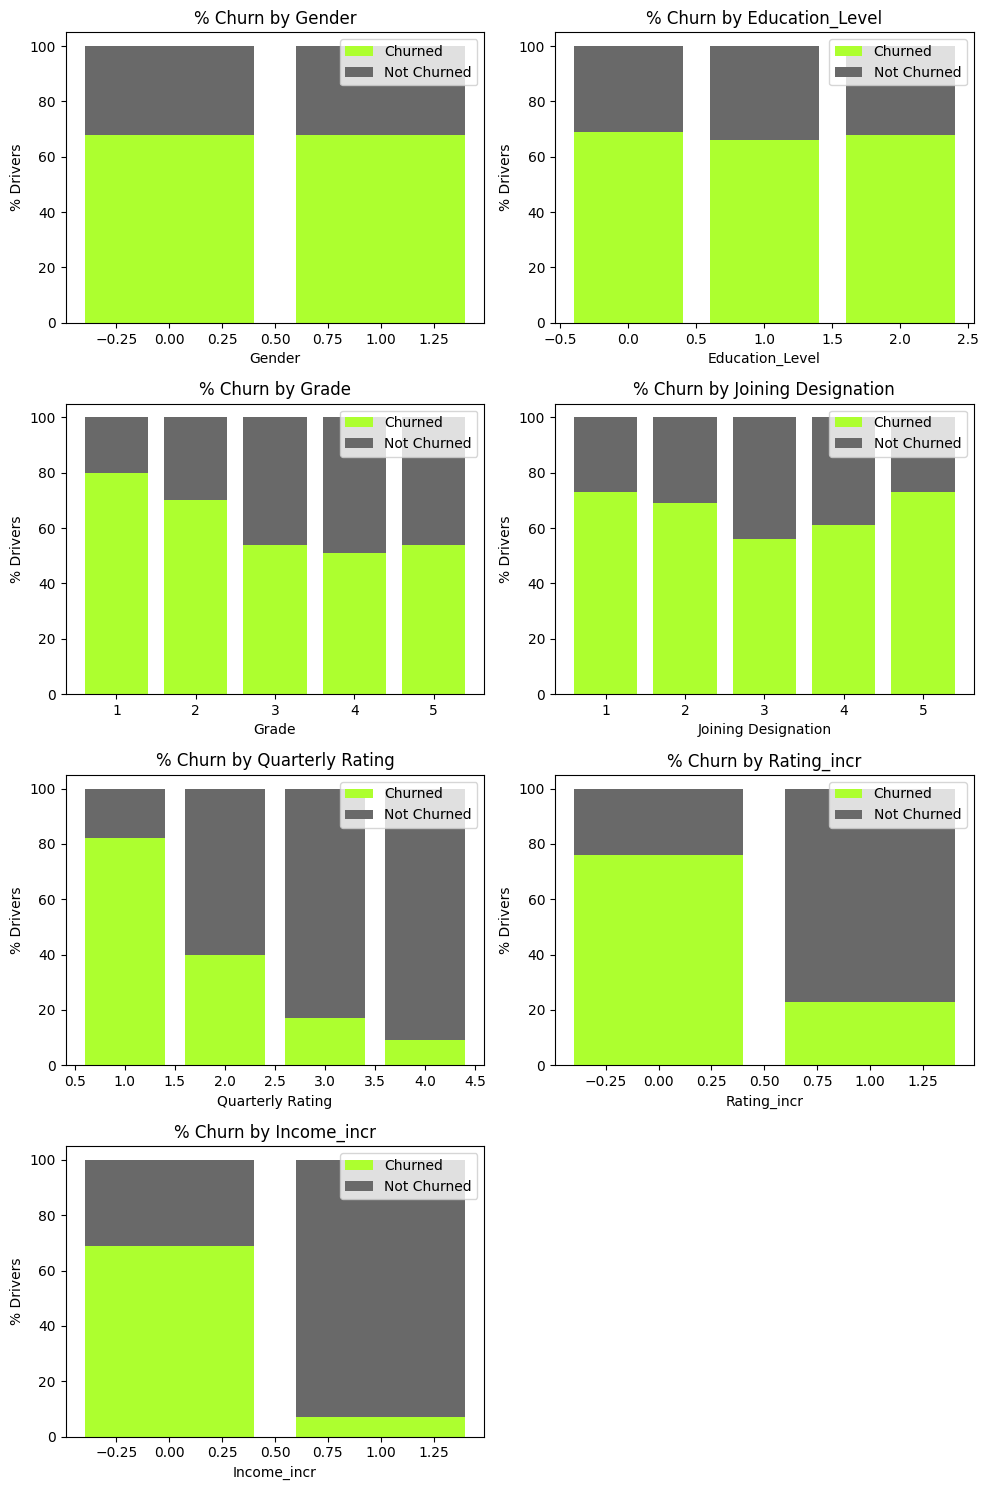

In [47]:

plt.figure(figsize=(10,15))
i=1
for col in cat1_cols:
    ax = plt.subplot(4, 2, i)

    data = df2.pivot_table(index=col, columns='Target', aggfunc='size')

    # Convert counts to percentages
    data = data.div(data.sum(axis=1), axis=0).multiply(100).round()
    data.reset_index(inplace=True)

    # Plotting the bars
    plt.bar(data[col], data[1], color='greenyellow',label='Churned')
    plt.bar(data[col], data[0], color='dimgrey', bottom=data[1],label='Not Churned')

    # Labeling and titles
    plt.xlabel(f'{col}')
    plt.ylabel('% Drivers')
    plt.title(f'% Churn by {col}')
    plt.legend(['Churned', 'Not Churned'])

    i += 1

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

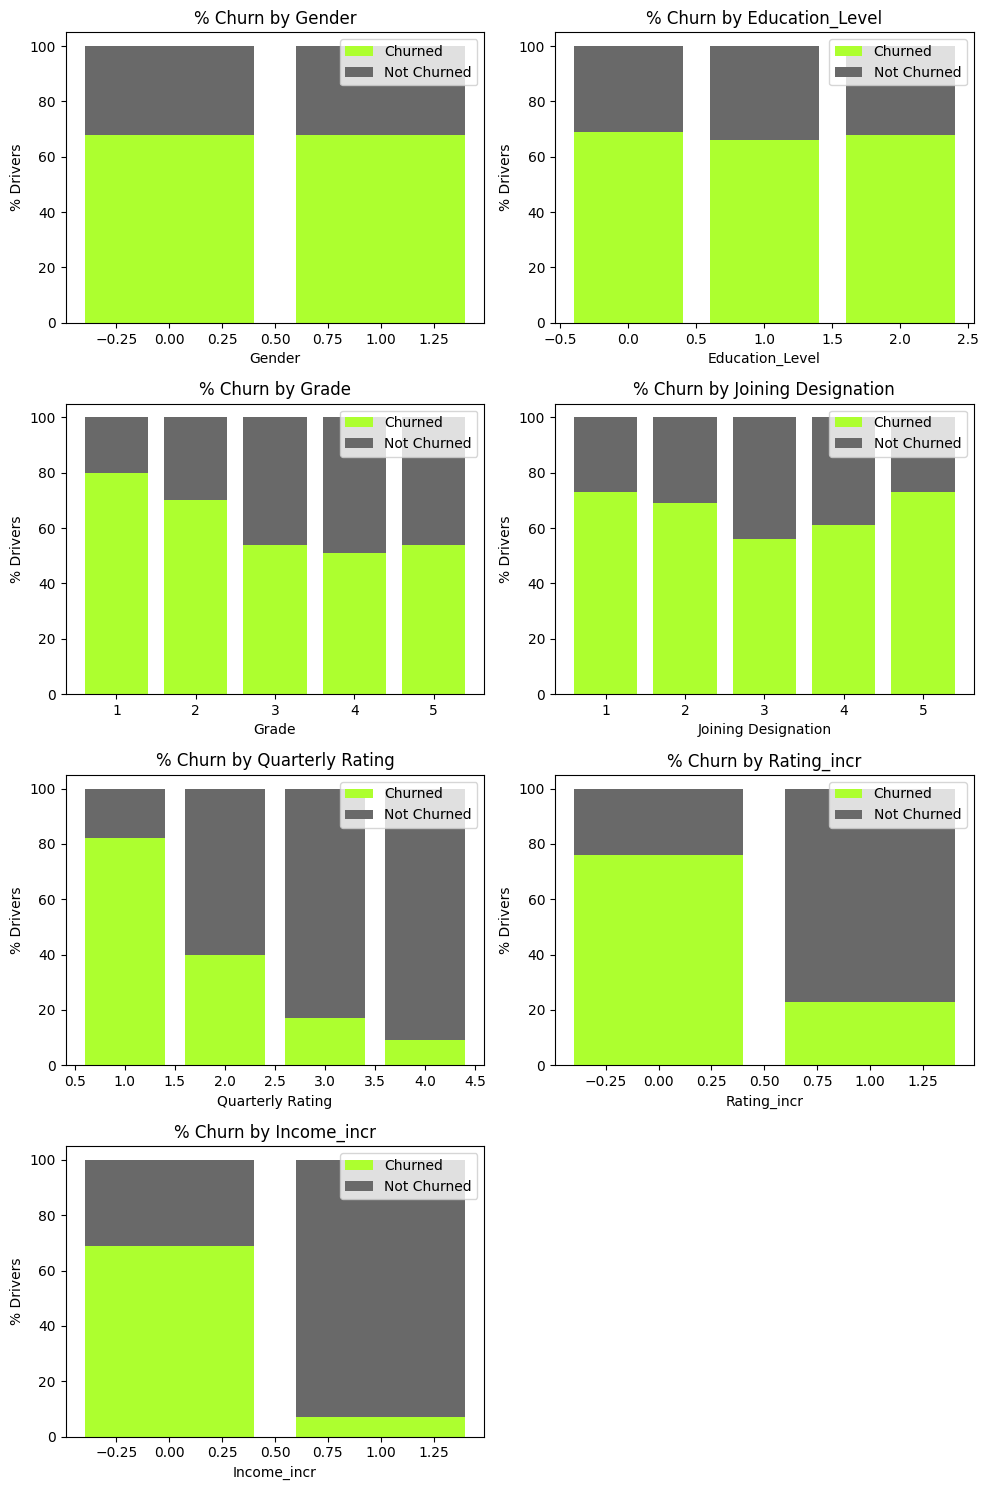

In [48]:

plt.figure(figsize=(10,15))
i=1
for col in cat1_cols:
    ax = plt.subplot(4, 2, i)

    data = df2.pivot_table(index=col, columns='Target', aggfunc='size')

    # Convert counts to percentages
    data = data.div(data.sum(axis=1), axis=0).multiply(100).round()
    data.reset_index(inplace=True)

    # Plotting the bars
    plt.bar(data[col], data[1], color='greenyellow',label='Churned')
    plt.bar(data[col], data[0], color='dimgrey', bottom=data[1],label='Not Churned')

    # Labeling and titles
    plt.xlabel(f'{col}')
    plt.ylabel('% Drivers')
    plt.title(f'% Churn by {col}')
    plt.legend(['Churned', 'Not Churned'])

    i += 1

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

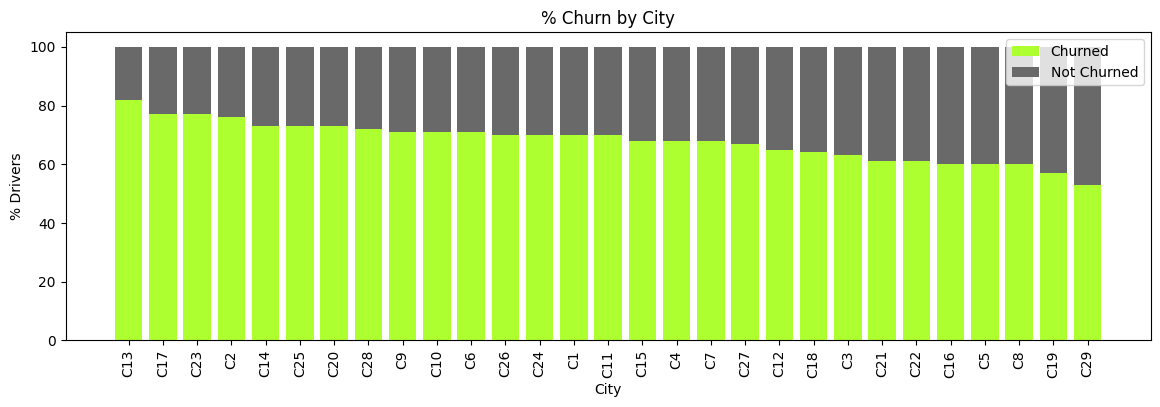

In [49]:
city = df2.pivot_table(index='City', columns='Target', aggfunc='size')
city = city.div(city.sum(axis=1), axis=0).multiply(100).round()
city.reset_index(inplace=True)
city = city.sort_values(by=1, ascending=False)

plt.figure(figsize=(14,4))
plt.bar(city['City'], city[1], color='greenyellow')
plt.bar(city['City'], city[0], color='dimgrey', bottom=city[1])

# Labeling and titles
plt.xlabel('City')
plt.ylabel('% Drivers')
plt.title(f'% Churn by City')
plt.legend(['Churned', 'Not Churned'])
plt.xticks(rotation=90)
plt.show()

Key notes:

Key Insights on Driver Churn:

* Gender and education level don’t seem to have any impact on churn.
* Grade 1 drivers had the highest churn rate at 80%, followed by Grade 2 at around 70%.
* The highest churn was seen among drivers who started with Designation 1 and 5, with nearly 75% leaving.
* Quarterly Rating appears to influence churn: 80% of those with a QR1 rating left, followed by 40% of QR2 and about 18% of QR3.
* Around 77% of drivers who didn’t see any improvement in their rating ended up leaving.
* Income growth also played a role—70% of those who didn’t get a raise decided to quit.
* Location mattered too—80% of drivers from City C13 left, with C17 and C23 not far behind.



# Correlation

In [50]:
numerical_df2 = df2.select_dtypes(include=['int64', 'float64'])

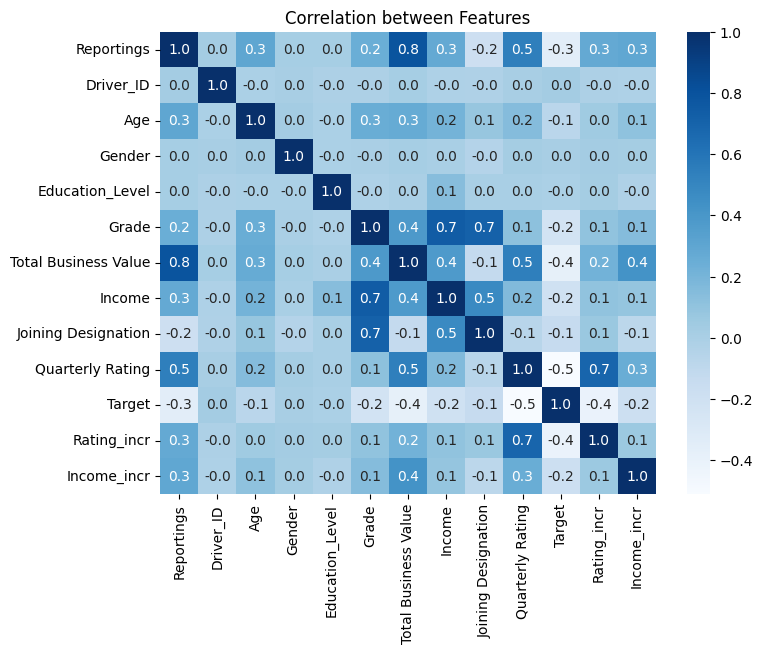

In [51]:
plt.figure(figsize=(8,6))
sns.heatmap(numerical_df2.corr(), annot=True, fmt=".1f",cmap='Blues')
plt.title('Correlation between Features')
plt.show()

### **Key Takeaways:**  

- **Reportings** show a strong positive correlation with **Total Business Value**.  
- **Quarterly Rating** and **Rating Increase** are closely related, which makes sense.  
- **Grade** has a strong positive correlation with **Income** and **Joining Designations**.  
- Based on these insights, we could consider dropping some features. However, **multicollinearity** isn’t just about individual feature pairs—it can result from multiple variables interacting together.  
- Simply using a correlation threshold to remove features might be misleading, as it doesn’t always capture the full impact on the model.  
- A better approach would be to finalize feature selection using **Feature Importance** analysis.  



## Data prep

In [52]:
df_prep=df2.drop(columns=['Driver_ID','LastWorkingDate'],axis=1)

In [53]:
df_prep['Month']=df_prep['Dateofjoining'].dt.month
df_prep['Year']=df_prep['Dateofjoining'].dt.year

In [54]:
df_prep.drop('Dateofjoining',axis=1,inplace=True)

In [55]:
df_encoded = pd.get_dummies(df_prep,'City', drop_first=True)*1

In [56]:
df_encoded.head()

,Reportings,Age,Gender,Education_Level,Grade,Total Business Value,Income,Joining Designation,Quarterly Rating,Target,...,City_C27,City_C28,City_C29,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9
0,3,28.0,0.0,2,1,1715580,57387,1,2,1,...,0,0,0,0,0,0,0,0,0,0
1,2,31.0,0.0,2,2,0,67016,2,1,0,...,0,0,0,0,0,0,0,1,0,0
2,5,43.0,0.0,2,2,350000,65603,2,1,1,...,0,0,0,0,0,0,0,0,0,0
3,3,29.0,0.0,0,1,120360,46368,1,1,1,...,0,0,0,0,0,0,0,0,0,1
4,5,31.0,1.0,1,3,1265000,78728,3,2,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
from sklearn.model_selection import train_test_split

In [58]:
X = df_encoded.drop(['Target'], axis=1)
y = df_encoded['Target']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
from sklearn.preprocessing import MinMaxScaler

In [61]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

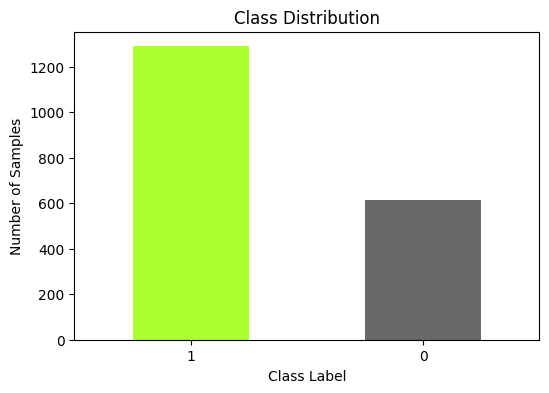

In [62]:
class_counts = y_train.value_counts()


plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=['greenyellow', 'dimgrey'])
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(rotation=0)
plt.show()

In [63]:
from imblearn.over_sampling import SMOTE

In [64]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

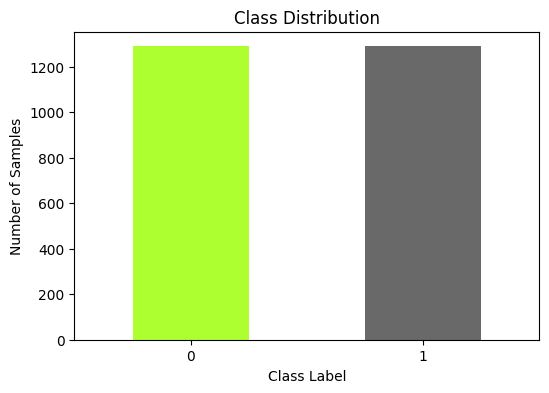

In [65]:
class_counts = y_train_res.value_counts()


plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=['greenyellow', 'dimgrey'])
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(rotation=0)
plt.show()

# Bagging(Random Forest Classifier)

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import time

In [67]:
params = {"max_depth":[7,10,15],
             "n_estimators":[100,200,300,400],
             "max_features":[4,7,10],
             "ccp_alpha":[0.0005,0.00075,0.001]}

In [68]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=params, cv=5, n_jobs=-1, verbose=2)

# Measure the time taken to fit the model
start_time = time.time()
grid_search.fit(X_train_res, y_train_res)
end_time = time.time()

print("Best parameters found by GridSearchCV:", grid_search.best_params_)
print(f"Total training time: {end_time - start_time:.2f} seconds")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found by GridSearchCV: {'ccp_alpha': 0.0005, 'max_depth': 15, 'max_features': 7, 'n_estimators': 100}
Total training time: 447.45 seconds


In [69]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay


In [70]:

# Retrieve the best model (estimator)
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_train_pred = best_model.predict(X_train_res)
y_test_pred = best_model.predict(X_test_scaled)

# Evaluate the model
# Accuracy
train_accuracy = accuracy_score(y_train_res, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")


Training Accuracy: 0.98
Test Accuracy: 0.89


In [71]:
grid_search.best_score_


0.9150666064574395

### **Observations:**  

- **Training Accuracy: 0.98** – The Random Forest model achieved **98% accuracy** on the training data, indicating that it fits the training set very well.  

- **Test Accuracy: 0.89** – When tested on unseen data, the model reached **89% accuracy**, showing that it generalizes well. The slight drop from training accuracy is normal and expected.  

- **Best Model Score: 0.915** – This represents the highest score obtained during cross-validation, likely using **GridSearchCV** for hyperparameter tuning. A score of **0.915** suggests that the model performed well across different validation sets.  

Overall, the model demonstrates **strong performance**, balancing accuracy on both training and test datasets.  


Feature Importance


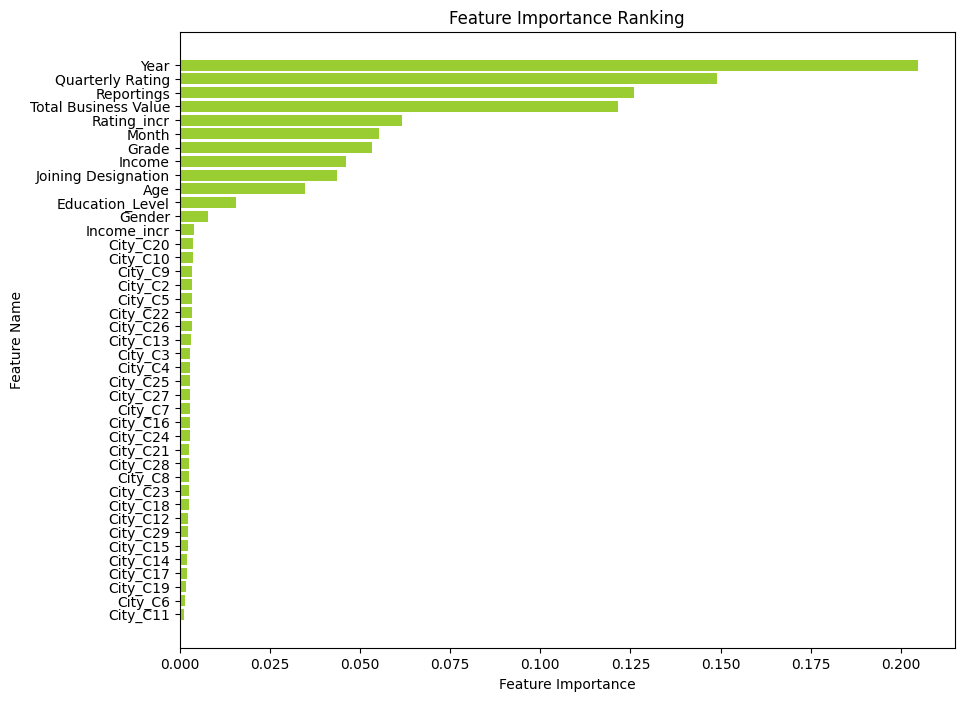

In [72]:
import matplotlib.pyplot as plt

# Retrieve feature importance values from the trained model
feature_importances = best_model.feature_importances_

# Create a dictionary to pair feature names with their corresponding importance scores
feature_importance_dict = {feature: importance for feature, importance in zip(X_train_res.columns, feature_importances)}

# Sort features based on their importance in descending order
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Separate the feature names and their importance scores for visualization
feature_names, importance_values = zip(*sorted_features)

# Plot the feature importance rankings
plt.figure(figsize=(10, 8))
plt.barh(feature_names, importance_values, color='yellowgreen')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance Ranking')
plt.gca().invert_yaxis()  # Ensures the most important features appear at the top
plt.show()


 Feature Importance in RandomForestClassifier  

- Year plays the most significant role in predicting Churn, followed by Quarterly Ratings, Reportings, and Business Values.  
- On the other hand, City and Income Increment have the least impact, followed by Education Level and Age.  
- Interestingly, our initial Exploratory Data Analysis (EDA) also suggested that Age and Education Level are not major factors influencing Churn.  
*italicized text*

ROC curve and AUC

In [73]:
from sklearn.metrics import roc_curve, roc_auc_score

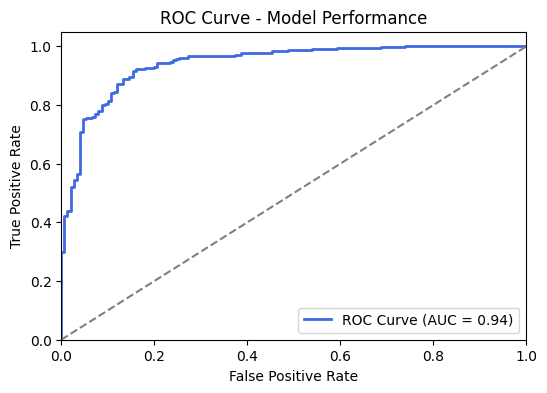

In [74]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Generate probability predictions on the test dataset
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculate the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute the Area Under the Curve (AUC) score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Visualizing the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='royalblue', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)  # Changed to 'royalblue'
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Reference line for a random model
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Model Performance')
plt.legend(loc='lower right')
plt.show()


 Performance Interpretation  

- AUC Score of 0.94 – This indicates that the model has a 94% probability of correctly distinguishing between a randomly selected positive case and a randomly selected negative case.  

- Strong Discriminative Power – The model effectively differentiates between the two classes, demonstrating high predictive accuracy.  

 Practical Implications  

- Model Dependability – With an AUC of 0.94, the model is highly reliable for predictions and has a low risk of misclassification.  

- Threshold Flexibility – A high AUC suggests that the model performs well across various threshold values, allowing adjustments to optimize sensitivity and specificity based on specific needs.  


Precision Recall curve

In [75]:
from sklearn.metrics import precision_recall_curve,auc

In [76]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

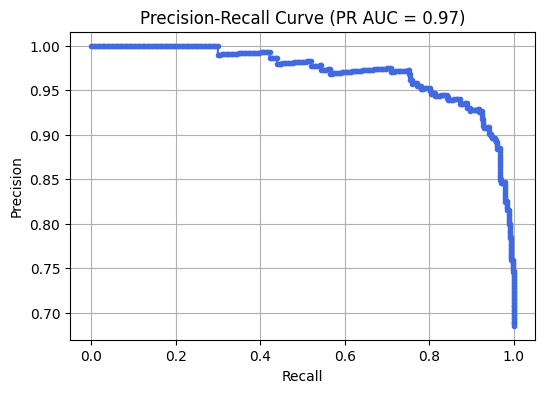

In [77]:
pr_auc = auc(recall, precision)

# Create a plot for the Precision-Recall curve
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.', color='royalblue')  # Changed color for uniqueness
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (PR AUC = {pr_auc:.2f})')
plt.grid(True)

# Display the plot
plt.show()

 High PR AUC:  

- A PR AUC of 0.97 indicates that the model maintains high precision and recall across various threshold settings.  
- This suggests the model effectively identifies positive cases while keeping false positives to a minimum.  

 Model Performance:  

- Strong Precision: The model rarely misclassifies negative instances as positive, meaning most predicted positives are correct.  
- High Recall: It successfully captures the majority of actual positive cases, minimizing false negatives.  

 Relevance in Imbalanced Datasets:  

- Why PR AUC Matters: In imbalanced datasets, where one class significantly outweighs the other, traditional metrics like accuracy can be misleading.  
- Better Minority Class Evaluation: PR AUC provides a more reliable measure of how well the model identifies the minority class, which is often the critical focus in such datasets.  


# Boosting (XGBoost)

In [78]:
import xgboost as xgb

In [79]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)

# Define the hyperparameter grid for tuning
gridParams = {
    'learning_rate': [0.1, 0.3, 0.5],
    'max_depth': [5, 6, 7, 8],
    'colsample_bytree': [0.5, 0.7],
    'subsample': [0.5, 0.7],
    'objective': ['binary:logistic'],  # Equivalent to LightGBM's 'binary'
    'booster': ['gbtree']  # Equivalent to LightGBM's 'gbdt'
}

# Set up GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=gridParams, cv=3, scoring='neg_log_loss', verbose=0)

# Train the model using GridSearchCV
grid.fit(X_train_res, y_train_res)

# Print best parameters and best score
print("Best parameters found: ", grid.best_params_)
print("Best log loss: ", -grid.best_score_)

Best parameters found:  {'booster': 'gbtree', 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'binary:logistic', 'subsample': 0.5}
Best log loss:  0.2328485707506095


In [80]:
# Retrieve the best model (estimator)
best_model = grid.best_estimator_

# Make predictions on the test set
y_train_pred = best_model.predict(X_train_res)
y_test_pred = best_model.predict(X_test_scaled)

# Evaluate the model
# Accuracy
train_accuracy = accuracy_score(y_train_res, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

Training Accuracy: 0.98
Test Accuracy: 0.89


 Key Observations:

- Log Loss (0.238): This indicates that the predicted probabilities are fairly accurate and closely align with the actual outcomes. Lower log loss suggests better probabilistic predictions.  
- Training Accuracy (96%): The model correctly classifies 96% of the training data, showing that it has effectively captured the patterns in the dataset.  
- Test Accuracy (90%): With a 90% accuracy on unseen data, the model demonstrates strong generalization ability, meaning it performs well on new inputs without overfitting.  


Confusion Matrix / Classification Report

In [81]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[121  29]
 [ 25 302]]


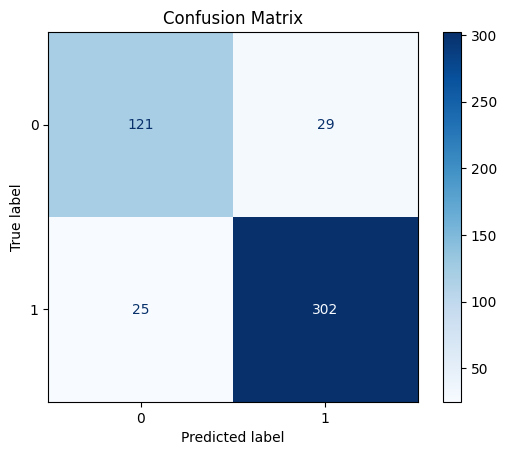

In [82]:
disp = ConfusionMatrixDisplay(conf_matrix)
cmap = plt.cm.Blues
disp.plot(cmap=cmap)
plt.title('Confusion Matrix')
plt.show()

In [83]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       150
           1       0.91      0.92      0.92       327

    accuracy                           0.89       477
   macro avg       0.87      0.87      0.87       477
weighted avg       0.89      0.89      0.89       477



Model Performance Summary

- Precision: How often the model’s positive predictions are correct.  
  - Class 0: 84% of predicted class 0 cases are right.  
  - Class 1: 92% of predicted class 1 cases are right.  

- Recall (Sensitivity): How well the model finds actual positive cases.  
  - Class 0: 82% of real class 0 cases are correctly identified.  
  - Class 1: 93% of real class 1 cases are correctly identified.  

- F1-Score: A balance between precision and recall.  
  - Class 0: 0.83  
  - Class 1: 0.92  
  - Overall Average: 0.90  

- Support: The number of actual cases in each class.  
  - Class 0: 150 samples  
  - Class 1: 327 samples  

- Accuracy: The model gets 90% of predictions right, showing strong performance.  


Feature Importance

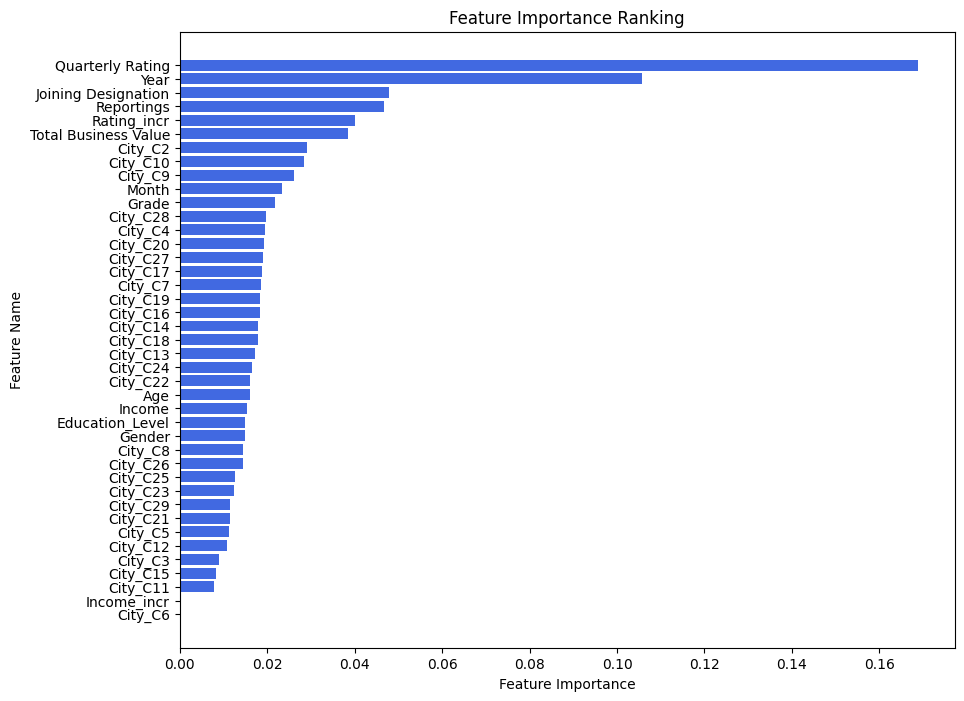

In [84]:
# Get feature importances from the model
feature_importances = best_model.feature_importances_

# Create a dictionary mapping feature names to their importance scores
feature_importance_dict = {feature: importance for feature, importance in zip(X_train_res.columns, feature_importances)}

# Sort features by importance in descending order
sorted_features = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Extract sorted feature names and their importance values
sorted_feature_names, sorted_importances = zip(*sorted_features)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_importances, color='royalblue')  # Changed color for variety
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance Ranking')
plt.gca().invert_yaxis()  # Highest importance appears at the top
plt.show()


 Observations:
- Total Business Value is the most influential factor, followed by Reportings and Income.  
- City has the least impact, along with Income Increment and Gender.  


ROC Curve & AUC



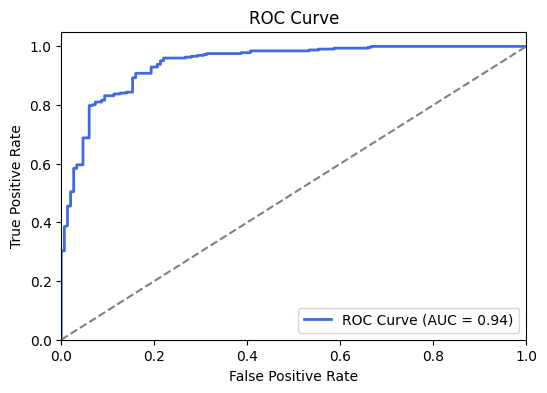

In [85]:
# Generate probability predictions on the test set
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve values and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='royalblue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')  # Changed color for better contrast
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line

# Formatting the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Display the plot
plt.show()


Precision Recall

In [86]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

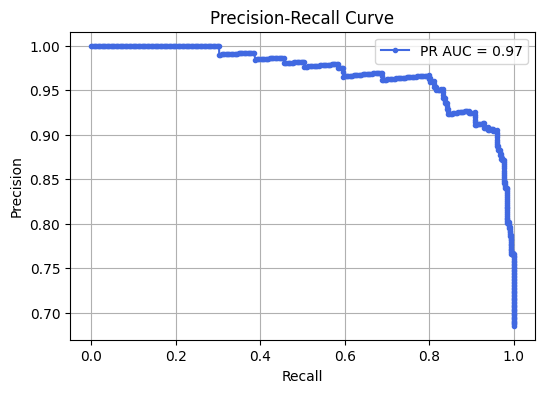

In [87]:
# Calculate Precision-Recall AUC
pr_auc = auc(recall, precision)

# Plot the Precision-Recall curve
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.', color='royalblue', label=f'PR AUC = {pr_auc:.2f}')  # Changed color for better contrast

# Formatting the plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


Observations:

- A PR AUC of 0.97 indicates that the model excels in maintaining a balance between precision and recall.
- This suggests that the model accurately identifies most positive cases while minimizing false positives and false negatives.
- Such a high PR AUC highlights the model's strong reliability, making it ideal for classification tasks where both precision and recall are crucial.
